# Implementation of "Split and Match"

This notebook includes the full pipeline (excluding color and contrast transfer) of the "Split and Match" Unsupervised Image Style Transfer method that was proposed in [Oriel Frigo](https://oriel.github.io/) et al.'s paper "Split and Match: Example-based Adaptive Patch Sampling for Unsupervised Style Transfer" (CVPR, 2016).




*   The original project page can be accessed [here](https://oriel.github.io/style_transfer.html).
*   This implementation was made by [Wangsheng Wu](https://www.wangshengwu.com).
*   The reproduction project page can be accessed [here](https://wangshengwu.com/en/computer-vision/image-style-transfer).


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import color
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import math
from PIL import Image

In [ ]:
# Constants
OMEGA = 450
MIN_PATCH_SIZE = 8
MAX_PATCH_SIZE = 256
K_CANDIDATES = 5
SPATIAL_SEPARATION_RATIO = 0.5

## Texture Transfer Functions

In [ ]:
def patch_distance(patch_u, patch_v):
    diff = patch_u - patch_v
    return np.sum(diff ** 2) / (patch_u.shape[0] * patch_u.shape[1])

def patch_std(patch):
    return np.std(patch)

def extract_patch(image, y0, x0, size):
    patch = image[y0:y0+size, x0:x0+size]
    if patch.shape[0] != size or patch.shape[1] != size:
        return None
    return patch

def best_match(patch_u, style_lab, size):
    h, w, _ = style_lab.shape
    best_dist = float('inf')
    for y in range(0, h - size + 1, size // 2):
        for x in range(0, w - size + 1, size // 2):
            patch_v = style_lab[y:y+size, x:x+size]
            if patch_v.shape[:2] != (size, size):
                continue
            dist = patch_distance(patch_u, patch_v)
            if dist < best_dist:
                best_dist = dist
    return best_dist

def flatten_patch(patch):
    return patch.flatten()

def extract_style_patches(style_lab, patch_size, stride=4):
    h, w, _ = style_lab.shape
    patches, coords = [], []
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = style_lab[y:y+patch_size, x:x+patch_size]
            if patch.shape[:2] == (patch_size, patch_size):
                patches.append(patch)
                coords.append((y, x))
    return np.array(patches), coords

def is_spatially_far(c1, c2, min_dist):
    return np.linalg.norm(np.array(c1) - np.array(c2)) >= min_dist

def select_candidate_labels(patch_u, style_lab, patch_size, k=5, spatial_sep_ratio=0.5):
    style_patches, coords = extract_style_patches(style_lab, patch_size)
    features = np.array([flatten_patch(p) for p in style_patches])
    feature_u = flatten_patch(patch_u).reshape(1, -1)
    if len(features) == 0:
        return []
    nbrs = NearestNeighbors(n_neighbors=min(len(features), 30)).fit(features)
    _, indices = nbrs.kneighbors(feature_u)

    selected, used_coords = [], []
    for idx in indices[0]:
        coord = coords[idx]
        if all(is_spatially_far(coord, u, patch_size * spatial_sep_ratio) for u in used_coords):
            selected.append(coord)
            used_coords.append(coord)
        if len(selected) >= k:
            break
    return selected

# QuadtreeNode Definition
class QuadtreeNode:
    def __init__(self, x0, y0, size, patch_u=None):
        self.x0 = x0
        self.y0 = y0
        self.size = size
        self.patch_u = patch_u
        self.children = []
        self.label_coords = []

    def is_leaf(self):
        return len(self.children) == 0

def split_node(node, img_lab, style_lab, print_log=False):
    y0, x0, size = node.y0, node.x0, node.size
    patch = extract_patch(img_lab, y0, x0, size)
    if patch is None:
        return

    sigma = patch_std(patch)
    match_dist = best_match(patch, style_lab, size)
    score = sigma + match_dist
    if print_log:
        print(f"Score: {score}")
    should_split = (score > OMEGA and size > MIN_PATCH_SIZE) or size > MAX_PATCH_SIZE

    if should_split:
        half = size // 2
        for dy in [0, half]:
            for dx in [0, half]:
                child = QuadtreeNode(x0 + dx, y0 + dy, half)
                split_node(child, img_lab, style_lab)
                node.children.append(child)
    else:
        node.patch_u = patch
        label_coords = select_candidate_labels(
            patch, style_lab, size,
            k=K_CANDIDATES,
            spatial_sep_ratio=SPATIAL_SEPARATION_RATIO
        )
        node.label_coords = label_coords


In [ ]:
def build_quadtree(img_lab, style_lab):
    h, w, _ = img_lab.shape
    size = 2 ** int(np.floor(np.log2(min(h, w))))
    root = QuadtreeNode(0, 0, size)
    split_node(root, img_lab, style_lab)
    return root

def collect_leaves(node):
    if node.is_leaf():
        return [node]
    leaves = []
    for child in node.children:
        leaves.extend(collect_leaves(child))
    return leaves

def visualize_partition(image_rgb, quadtree_root, color=(0, 0, 0), thickness=1):
    vis = image_rgb.copy()
    leaves = collect_leaves(quadtree_root)
    for node in leaves:
        x0, y0, size = node.x0, node.y0, node.size
        cv2.rectangle(vis, (x0, y0), (x0 + size, y0 + size), color, thickness)
    plt.figure(figsize=(6, 6))
    plt.imshow(vis)
    plt.axis("off")
    plt.show()
    # return vis

In [ ]:
# content_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/content-1.jpg"
# style_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/style-woman.jpg"

# # content_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/cat-2.jpg"
# # style_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/style-van-gogh.jpg"

# # Load content and style images
# content = cv2.imread(content_path)
# style = cv2.imread(style_path)
# content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB)
# style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB)

# # Resize (optional)
# content = cv2.resize(content, (512, 512))
# style = cv2.resize(style, (512, 512))

# # Convert to Lab
# content_lab = color.rgb2lab(content)
# style_lab = color.rgb2lab(style)

# # Build and visualize adaptive quadtree
# root = build_quadtree(content_lab, style_lab)
# visualize_partition(content, root)

In [ ]:
def visualize_patch_and_candidates(content_rgb, style_rgb, tree, content_y, content_x, show_patch=False):
    """
    Combined visualization:
    - Show selected content patch on content image.
    - Show candidate style patch rectangles on style image.
    - Optionally show actual content patch image.
    """

    # --- Step 1: Find the node in the quadtree ---
    target_node = None
    for node in tree:
        y0, x0, size = node.y0, node.x0, node.size
        if y0 <= content_y < y0 + size and x0 <= content_x < x0 + size:
            target_node = node
            break

    if target_node is None:
        print("No matching node found for this point.")
        return

    if not hasattr(target_node, "label_coords"):
        print("No label_coords attribute found in this node.")
        return

    # --- Step 2: Visualize content patch position ---
    content_vis = content_rgb.copy()
    leaves = tree
    for node in leaves:
        x0, y0, size = node.x0, node.y0, node.size
        cv2.rectangle(content_vis, (x0, y0), (x0 + size, y0 + size), (220, 220, 220), 1)
    cv2.rectangle(content_vis,
                  (target_node.x0, target_node.y0),
                  (target_node.x0 + target_node.size, target_node.y0 + target_node.size),
                  (255, 0, 0), 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(content_vis)
    plt.title(f"Content Patch at ({content_y}, {content_x}) — Size {target_node.size}")
    plt.axis('off')
    plt.show()

    # --- Step 3: Visualize candidate patches on style image ---
    vis_style = style_rgb.copy()
    for (y, x) in target_node.label_coords:
        cv2.rectangle(vis_style, (x, y), (x + target_node.size, y + target_node.size), (0, 255, 0), 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(vis_style)
    plt.title("Style Candidates")
    plt.axis("off")
    plt.show()

    # --- Step 4: Show the content patch itself ---
    if show_patch and hasattr(target_node, "patch_u"):
        patch_rgb = color.lab2rgb(target_node.patch_u)
        plt.figure()
        plt.imshow(np.clip(patch_rgb, 0, 1))
        plt.title("Content Patch (LAB → RGB)")
        plt.axis("off")
        plt.show()


In [ ]:
# tree = collect_leaves(root)
# visualize_patch_and_candidates(content, style, tree, content_y=150, content_x=170)

In [ ]:
def get_adjacency(tree):
    pos_map = {(node.y0, node.x0): i for i, node in enumerate(tree)}
    adj = set()
    for i, node in enumerate(tree):
        y0, x0, s = node.y0, node.x0, node.size
        neighbors = [(y0 + s, x0), (y0 - s, x0), (y0, x0 + s), (y0, x0 - s)]
        for (ny, nx) in neighbors:
            j = pos_map.get((ny, nx))
            if j is not None and i != j:
                adj.add(tuple(sorted((i, j))))
    return list(adj)

def compute_unary_energies(tree, style_lab):
    lambda_d = 2.0
    unary_energy = []
    for node in tree:
        energies = []
        size = node.size
        for (y, x) in node.label_coords:
            patch_v = extract_patch(style_lab, y, x, size)
            if patch_v is None:
                energies.append(1e6)
                continue
            dist = patch_distance(node.patch_u, patch_v)
            E = lambda_d * dist
            energies.append(E)
        unary_energy.append(np.array(energies))
    return unary_energy

def compute_pairwise_energies(tree, style_lab):
    lambda_s = 2.0
    lambda_r = 1.0
    adj = get_adjacency(tree)
    pairwise_energy = {}
    for i, j in adj:
        node_i = tree[i]
        node_j = tree[j]
        size_i, size_j = node_i.size, node_j.size
        overlap = min(size_i, size_j)
        psi = np.zeros((len(node_i.label_coords), len(node_j.label_coords)))
        for ki, (yi, xi) in enumerate(node_i.label_coords):
            for kj, (yj, xj) in enumerate(node_j.label_coords):
                pi = extract_patch(style_lab, yi, xi, overlap)
                pj = extract_patch(style_lab, yj, xj, overlap)
                if pi is None or pj is None or pi.shape != pj.shape:
                    energy = 1e6
                else:
                    d = patch_distance(pi, pj)
                    repeat = np.linalg.norm(np.array([yi, xi]) - np.array([yj, xj]))
                    energy = lambda_s * d - lambda_r * repeat ** 2
                psi[ki, kj] = energy
        pairwise_energy[(i, j)] = psi
    return pairwise_energy

def run_min_sum_loopy_belief_propagation_variable(unary_energy, pairwise_energy, label_sizes, max_iters=5):
    n = len(unary_energy)
    messages = defaultdict(lambda: None)

    for (i, j), E_ij in pairwise_energy.items():
        messages[(i, j)] = np.zeros(E_ij.shape[1])
        messages[(j, i)] = np.zeros(E_ij.shape[0])

    for _ in range(max_iters):
        new_messages = {}
        for (i, j), E_ij in pairwise_energy.items():
            li, lj = E_ij.shape
            msg = np.zeros(lj)
            for l_j in range(lj):
                costs = []
                for l_i in range(li):
                    incoming = 0.0
                    for k in range(n):
                        if (k, i) in pairwise_energy and k != j:
                            incoming += messages[(k, i)][l_i]
                    cost = unary_energy[i][l_i] + incoming + E_ij[l_i, l_j]
                    costs.append(cost)
                msg[l_j] = min(costs)
            new_messages[(i, j)] = msg
        messages.update(new_messages)
    return messages

def infer_best_label(tree, unary_energy, messages, pairwise_energy):
    labels = []
    for i in range(len(tree)):
        total_energy = unary_energy[i].copy()
        for (j, k), E in pairwise_energy.items():
            if i == j:
                total_energy += messages[(k, j)][:len(total_energy)]
            elif i == k:
                total_energy += messages[(j, k)][:len(total_energy)]
        labels.append(np.argmin(total_energy))
    return labels

In [ ]:
def visualize_label_assignments(style_rgb, tree, labels, color=(0, 255, 0), thickness=1):
    """
    Overlay rectangles on the style image at the positions of the selected labels.
    Each rectangle corresponds to the assigned style patch for one quadtree node.
    """
    vis = style_rgb.copy()

    for node, label_idx in zip(tree, labels):
        if label_idx >= len(node.label_coords):
            continue
        y, x = node.label_coords[label_idx]
        size = node.size
        cv2.rectangle(vis, (x, y), (x + size, y + size), color, thickness)

    plt.figure(figsize=(8, 8))
    plt.imshow(vis)
    plt.axis("off")
    plt.show()
    # return vis


def locate_style_label(content_rgb, style_rgb, tree, labels, content_y, content_x, show_partition=True, show_all_labels=True):
    """
    Given a coordinate in the content image, visualize the corresponding assigned style patch
    with a square drawn on the style image.
    """
    target_node = None
    for i, node in enumerate(tree):
        y0, x0, size = node.y0, node.x0, node.size
        if y0 <= content_y < y0 + size and x0 <= content_x < x0 + size:
            target_node = node
            label_index = labels[i]
            break

    if target_node is None:
        print("No matching content patch found.")
        return

    if label_index >= len(target_node.label_coords):
        print("Assigned label index out of bounds.")
        return

    style_y, style_x = target_node.label_coords[label_index]
    patch_size = target_node.size

    # Visualize content patch location
    plt.figure(figsize=(6, 6))
    content_vis = content_rgb.copy()

    if show_partition:
        leaves = tree
        for node in leaves:
            x0, y0, size = node.x0, node.y0, node.size
            cv2.rectangle(content_vis, (x0, y0), (x0 + size, y0 + size), (220, 220, 220), 1)

    cv2.rectangle(content_vis, (target_node.x0, target_node.y0),
                  (target_node.x0 + patch_size, target_node.y0 + patch_size), (255, 0, 0), 1)
    plt.imshow(content_vis)
    plt.title(f"Content Patch at ({content_y}, {content_x})")
    plt.axis("off")
    plt.show()

    # Visualize assigned style patch on the style image
    plt.figure(figsize=(6, 6))
    style_vis = style_rgb.copy()

    if show_all_labels:
        for node, label_idx in zip(tree, labels):
          if label_idx >= len(node.label_coords):
              continue
          y, x = node.label_coords[label_idx]
          size = node.size
          cv2.rectangle(style_vis, (x, y), (x + size, y + size), (220, 220, 220), 1)


    cv2.rectangle(style_vis, (style_x, style_y),
                  (style_x + patch_size, style_y + patch_size), (0, 255, 0), 1)
    plt.imshow(style_vis)
    plt.title("Assigned Style Patch")
    plt.axis("off")
    plt.show()

In [ ]:
# unary_energy = compute_unary_energies(tree, style_lab)
# pairwise_energy = compute_pairwise_energies(tree, style_lab)
# messages = run_min_sum_loopy_belief_propagation_variable(unary_energy, pairwise_energy, label_sizes=None)
# labels = infer_best_label(tree, unary_energy, messages, pairwise_energy)

In [ ]:
# visualize_label_assignments(style, tree, labels)

In [ ]:
# locate_style_label(content, style, tree, labels, content_y=50, content_x=180)

In [ ]:
def just_reconstruct(tree, style_lab, labels):
    h, w, _ = style_lab.shape
    result = np.zeros((h, w, 3), dtype=np.float32)
    weight = np.zeros((h, w, 1), dtype=np.float32)

    for i, node in enumerate(tree):
        y0, x0, size = node.y0, node.x0, node.size
        label_idx = labels[i]
        if label_idx >= len(node.label_coords):
            continue
        sy, sx = node.label_coords[label_idx]
        patch = extract_patch(style_lab, sy, sx, size)
        if patch is None:
            continue
        for dy in range(size):
            for dx in range(size):
                yy, xx = y0 + dy, x0 + dx
                if yy >= h or xx >= w:
                    continue
                wy = 1 - abs(dy - size/2) / (size/2)
                wx = 1 - abs(dx - size/2) / (size/2)
                alpha = 0.1 + 0.9 * wy * wx
                result[yy, xx] += alpha * patch[dy, dx]
                weight[yy, xx] += alpha

    blended = result / np.maximum(weight, 1e-8)
    return blended

In [ ]:
# result_lab = just_reconstruct(tree, style_lab, labels)
# result_rgb = color.lab2rgb(result_lab)
# plt.figure(figsize=(6, 6))
# plt.imshow(np.clip(result_rgb, 0, 1))
# plt.axis("off")
# plt.show()

In [ ]:
def compute_distance_to_border(y, x, patch_y0, patch_x0, patch_h, patch_w, patch_size):
    """
    Compute normalized squared distance from (y, x) to the nearest border of the patch.
    This follows Eq. (8) in the paper.
    """
    top = y - patch_y0
    left = x - patch_x0
    bottom = (patch_y0 + patch_h - 1) - y
    right = (patch_x0 + patch_w - 1) - x
    min_dist = min(top, left, bottom, right)
    return (min_dist ** 2) / (patch_size ** 2 + 1e-6)


def bilinear_blending_with_overlap(tree, style_lab, labels, theta=0.5):
    """
    Bilinear blending with overlapping patches as defined in Section 3.4 of the paper.
    Each patch contributes to the final image based on its distance to the patch boundary.
    """
    h, w, _ = style_lab.shape
    result = np.zeros((h, w, 3), dtype=np.float32)
    contribs = {}  # key: (y, x), value: list of (color, weight)

    for i, node in enumerate(tree):
        y0, x0, size = node.y0, node.x0, node.size
        label_idx = labels[i]
        if label_idx >= len(node.label_coords):
            continue

        sy, sx = node.label_coords[label_idx]

        # Define extended region in style image
        ext = int(size * theta)
        ext_sy = max(0, sy - ext)
        ext_sx = max(0, sx - ext)
        ext_sy1 = min(style_lab.shape[0], sy + size + ext)
        ext_sx1 = min(style_lab.shape[1], sx + size + ext)
        patch_ext = style_lab[ext_sy:ext_sy1, ext_sx:ext_sx1]

        # Define extended region in output image
        ext_y0 = max(0, y0 - ext)
        ext_x0 = max(0, x0 - ext)
        ext_y1 = min(h, y0 + size + ext)
        ext_x1 = min(w, x0 + size + ext)

        patch_h, patch_w = patch_ext.shape[:2]

        for dy in range(patch_h):
            for dx in range(patch_w):
                yy = ext_y0 + dy
                xx = ext_x0 + dx
                if not (0 <= yy < h and 0 <= xx < w):
                    continue

                d = compute_distance_to_border(
                    yy, xx,
                    ext_y0, ext_x0,
                    patch_h, patch_w,
                    size  # tau_s (original, unextended patch size)
                )
                weight = d + 1e-6  # Avoid division by zero
                key = (yy, xx)
                if key not in contribs:
                    contribs[key] = []
                contribs[key].append((patch_ext[dy, dx], weight))

    # Normalize and combine contributions
    for (yy, xx), entries in contribs.items():
        weights = np.array([w for _, w in entries], dtype=np.float32)
        colors = np.array([c for c, _ in entries], dtype=np.float32)
        weights /= np.sum(weights) + 1e-6
        result[yy, xx] = np.sum(weights[:, None] * colors, axis=0)

    return result

In [ ]:
# result_lab = bilinear_blending_with_overlap(tree, style_lab, labels)
# result_rgb = color.lab2rgb(result_lab)

# plt.figure(figsize=(6, 6))
# plt.imshow(np.clip(result_rgb, 0, 1))
# plt.title("Final Stylized Output with True Bilinear Blending")
# plt.axis("off")
# plt.show()

In [ ]:
def save_image(image_array, file_path):
    # Ensure it's in the correct format for saving
    image_uint8 = (np.clip(image_array, 0, 1) * 255).astype(np.uint8)
    image_pil = Image.fromarray(image_uint8)
    image_pil.save(file_path)
    print(f"Image saved to {file_path}")

In [ ]:
def visualize_patch_overlap_at_pixel(content_rgb, tree, labels, pixel_y, pixel_x, zoom=64):
    """
    Visualize all extended overlapping patches (green),
    the original content patch (orange),
    and all original patches in the zoomed region (white).
    """
    vis = content_rgb.copy()
    h, w, _ = vis.shape
    region_half = zoom // 2

    overlapping_patches = []
    original_patch = None
    zoomed_patches = []

    # Precompute zoomed region bounds
    y1_zoom = max(pixel_y - region_half, 0)
    y2_zoom = min(pixel_y + region_half, h)
    x1_zoom = max(pixel_x - region_half, 0)
    x2_zoom = min(pixel_x + region_half, w)

    for i, node in enumerate(tree):
        y0, x0, size = node.y0, node.x0, node.size
        ext = int(size * 0.5)
        ey0, ex0 = y0 - ext, x0 - ext
        ey1, ex1 = y0 + size + ext, x0 + size + ext

        # All overlapping extended patches
        if ey0 <= pixel_y < ey1 and ex0 <= pixel_x < ex1:
            overlapping_patches.append((ex0, ey0, size + 2 * ext))

        # Original patch containing the pixel
        if y0 <= pixel_y < y0 + size and x0 <= pixel_x < x0 + size:
            original_patch = (x0, y0, size)

        # All patches in the zoom window
        if (x0 + size > x1_zoom and x0 < x2_zoom) and (y0 + size > y1_zoom and y0 < y2_zoom):
            zoomed_patches.append((x0, y0, size))

    # Draw all zoomed patches in white
    for (x, y, s) in zoomed_patches:
        x1, y1 = max(x, 0), max(y, 0)
        x2, y2 = min(x + s, w), min(y + s, h)
        cv2.rectangle(vis, (x1, y1), (x2, y2), (255, 255, 255), 1)

    # Draw extended overlapping patches (green)
    for (x, y, s) in overlapping_patches:
        x1, y1 = max(x, 0), max(y, 0)
        x2, y2 = min(x + s, w), min(y + s, h)
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 1)

    # Draw the original patch (orange)
    if original_patch:
        x0, y0, size = original_patch
        x1, y1 = max(x0, 0), max(y0, 0)
        x2, y2 = min(x0 + size, w), min(y0 + size, h)
        cv2.rectangle(vis, (x1, y1), (x2, y2), (255, 165, 0), 1)

    # Draw the center pixel
    cv2.circle(vis, (pixel_x, pixel_y), radius=0, color=(255, 0, 0), thickness=-1)

    # Zoomed crop
    zoomed = vis[y1_zoom:y2_zoom, x1_zoom:x2_zoom]

    plt.figure(figsize=(6, 6))
    plt.imshow(zoomed)
    plt.title(f"Patches Overlapping Pixel ({pixel_y}, {pixel_x})")
    plt.axis("off")
    plt.show()

In [ ]:
# visualize_patch_overlap_at_pixel(content, tree, labels, pixel_y=299, pixel_x=321)

## Full process automation

In [ ]:
def lets_transfer(content_path, style_path):
    # Load content and style images
    content = cv2.imread(content_path)
    style = cv2.imread(style_path)
    content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB)
    style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB)

    # Resize (optional)
    content = cv2.resize(content, (512, 512))
    style = cv2.resize(style, (512, 512))

    # Convert to Lab
    content_lab = color.rgb2lab(content)
    style_lab = color.rgb2lab(style)

    # Build and visualize adaptive quadtree
    root = build_quadtree(content_lab, style_lab)
    visualize_partition(content, root)

    # # Visualize candidate patch selection
    # tree = collect_leaves(root)
    # visualize_patch_and_candidates(content, style, tree, content_y=150, content_x=170)


    tree = collect_leaves(root)
    unary_energy = compute_unary_energies(tree, style_lab)
    pairwise_energy = compute_pairwise_energies(tree, style_lab)
    messages = run_min_sum_loopy_belief_propagation_variable(unary_energy, pairwise_energy, label_sizes=None)
    labels = infer_best_label(tree, unary_energy, messages, pairwise_energy)


    result_lab = just_reconstruct(tree, style_lab, labels)
    result_rgb = color.lab2rgb(result_lab)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.clip(result_rgb, 0, 1))
    plt.axis("off")
    plt.show()

    result_lab = bilinear_blending_with_overlap(tree, style_lab, labels)
    result_rgb = color.lab2rgb(result_lab)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.clip(result_rgb, 0, 1))
    plt.axis("off")
    plt.show()

## Run the transfer

In [ ]:
content_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/content-1.jpg"
style_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/style-2.jpg"
OMEGA = 410
lets_transfer(content_path, style_path)

Output hidden; open in https://colab.research.google.com to view.

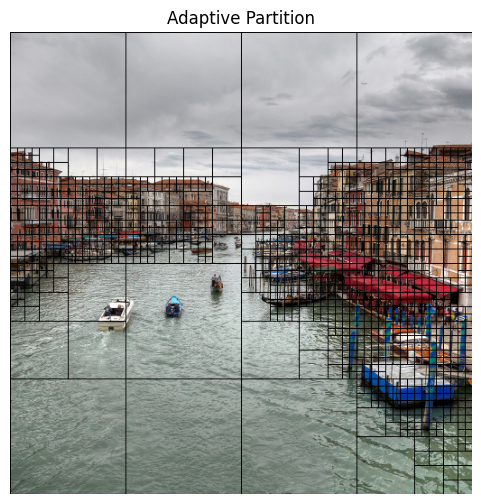

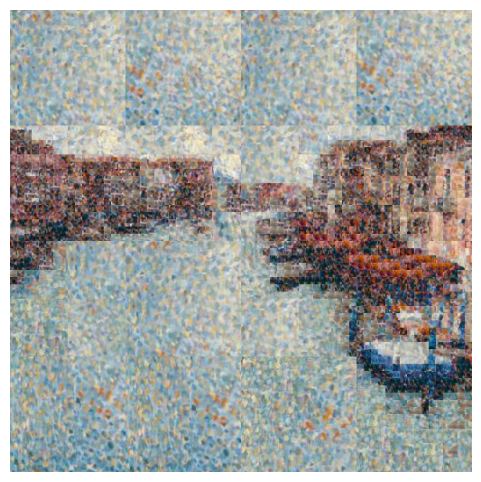

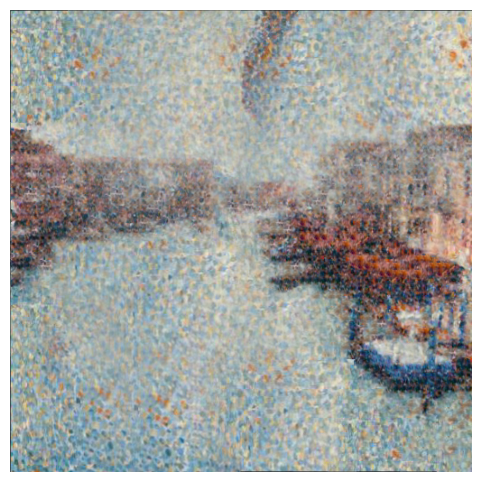

In [ ]:
content_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/content-venice.jpg"
style_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/style-woman.jpg"
OMEGA = 500
lets_transfer(content_path, style_path)

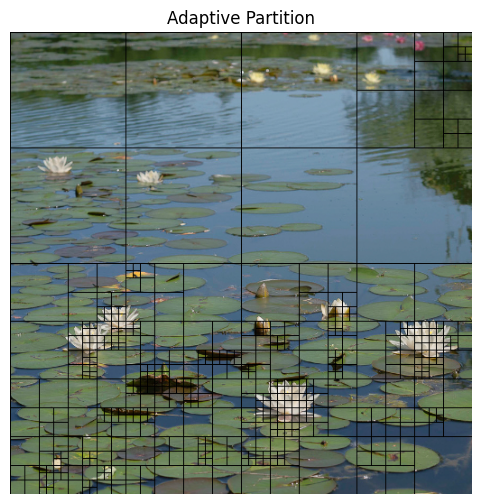

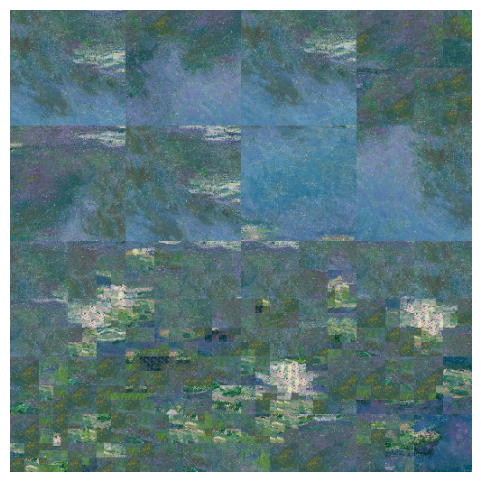

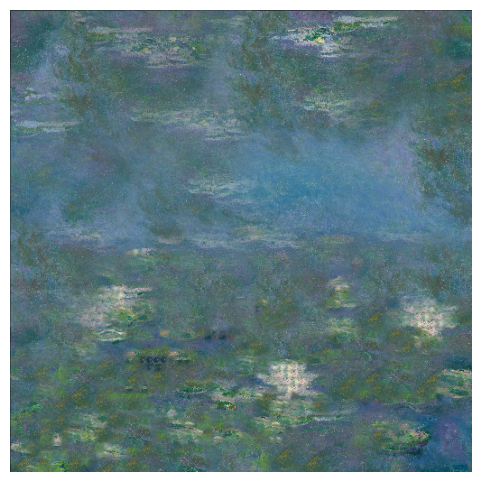

In [ ]:
content_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/content-water-lilies-3.jpg"
style_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/style-water-lilies.jpg"
OMEGA = 520
lets_transfer(content_path, style_path)

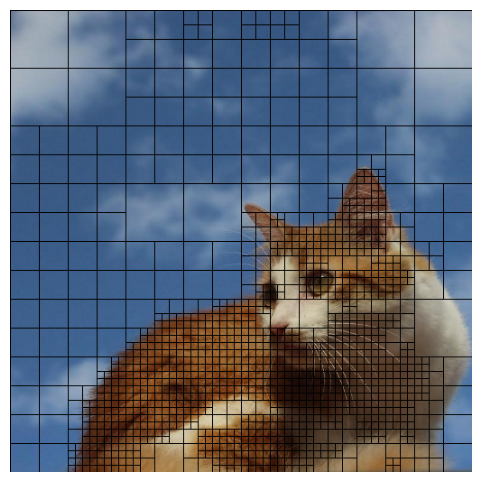

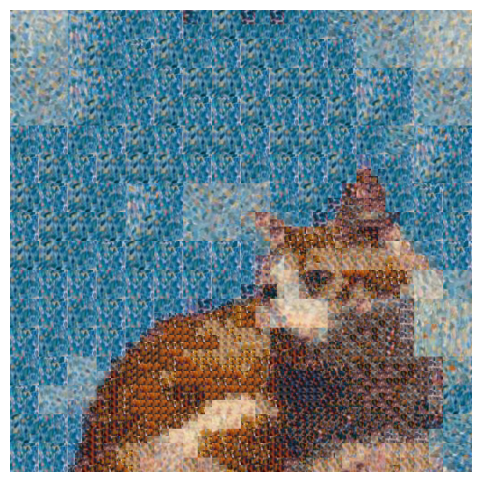

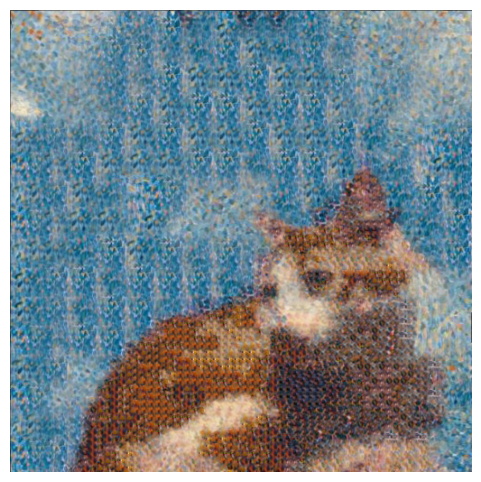

In [ ]:
content_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/content-1.jpg"
style_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/style-woman.jpg"
OMEGA = 500
lets_transfer(content_path, style_path)

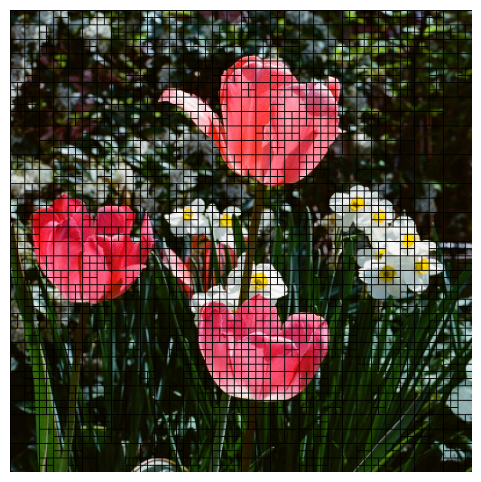

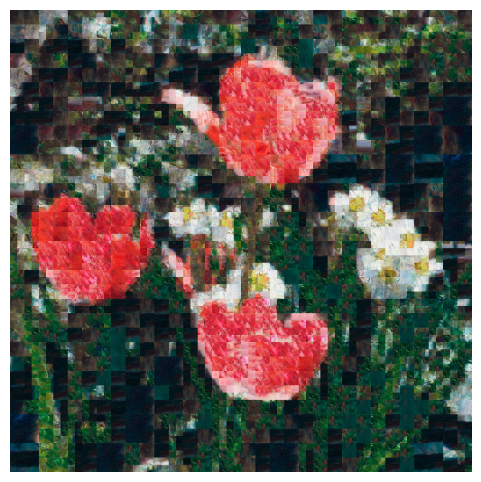

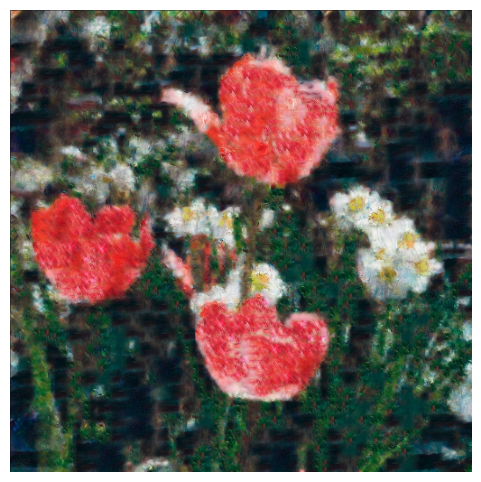

In [ ]:
content_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/content-flowers.jpg"
style_path = "/content/drive/MyDrive/Computer Vision/Image Style Transfer/Dataset/style-renoir.jpg"
OMEGA = 450
lets_transfer(content_path, style_path)